In [454]:
import pandas as pd
import numpy as np
import data_preprocess as dp
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import pickle

In [455]:
data = pd.read_csv('./data/D2.csv')

In [456]:
df = dp.data_prep(data)

In [457]:
# drop the rows with where discharge_disposition is deceased
df = df[df.discharge_disposition != 'Deceased']

In [458]:
rs = 1

In [459]:
# Step 1: Separating the features and target variable
X = df.drop('readmitted', axis=1)  # Features
y = df['readmitted']  # Target

In [460]:
with open('./data/DT.pkl', 'rb') as file:
    dt_model = pickle.load(file)

In [461]:
feature_importances = dt_model.feature_importances_

In [462]:
# Identifying categorical columns that need encoding
categorical_columns = ['race', 'medical_specialty', 'admission_type', 'discharge_disposition', 'admission_source']
numerical_columns = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                     'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                     'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'insulin', 'change', 'diabetesMed']

In [463]:
label_encoder = LabelEncoder()
X['age'] = label_encoder.fit_transform(X['age'])

In [464]:
X = pd.get_dummies(X, columns=categorical_columns, dtype=int)

In [465]:
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])


In [466]:
important_features_array = np.where(dt_model.feature_importances_ > 0)[0] # select features with importance greater than 0 from the previous decision tree model

In [467]:
important_features_array

array([ 1,  5,  6,  7,  8,  9, 26, 29, 30, 35], dtype=int64)

In [468]:
important_features_df = X.iloc[:, important_features_array]

In [469]:
X = important_features_df

In [470]:
X.columns

Index(['age', 'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Other',
       'medical_specialty_Internal Medicine', 'medical_specialty_Other',
       'discharge_disposition_AdditonalCare'],
      dtype='object')

In [471]:
from sklearn.model_selection import train_test_split

In [472]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)

In [473]:
# Import the model
from sklearn.linear_model import LogisticRegression

# Instantiate the default model
log_reg = LogisticRegression(random_state=rs)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [474]:
# perform cross validation with gridsearchCV
from sklearn.model_selection import GridSearchCV


In [475]:
# defining the hyperparameters
params = {
    'C': [pow(10, x) for x in range(-4, 6)],
}

In [476]:
# Instantiating the gridsearch
grid_search = GridSearchCV(param_grid=params, estimator=log_reg, return_train_score=True,
                           cv=10, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             return_train_score=True, verbose=1)

In [477]:
# best hyperparameters  
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'C': 0.01}


In [478]:
coefs = grid_search.best_estimator_.coef_[0]
importance = np.abs(coefs)
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importance)
indices = np.flip(indices, axis=0)

# limit to 5 features
indices = indices[:5]

top_5_features = feature_names[indices]
top_5_importance = importance[indices]

for i in range(5):
    print(f"{top_5_features[i]} -> {top_5_importance[i]:.3f}")


number_inpatient -> 0.536
number_emergency -> 0.286
medical_specialty_Internal Medicine -> 0.217
medical_specialty_Other -> 0.140
number_outpatient -> 0.137


In [479]:
# Training and test accuracy
from sklearn.metrics import accuracy_score

# Predict on the training and test sets
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Calculate training and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy scores
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6248
Test Accuracy: 0.6242


In [480]:
grid_search.best_params_

{'C': 0.01}

In [481]:
from sklearn.feature_selection import RFECV

In [482]:
rfe = RFECV(estimator=log_reg, min_features_to_select=5, cv=10,  n_jobs=-1, verbose=1)
rfe.fit(X_train, y_train)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.


RFECV(cv=10, estimator=LogisticRegression(random_state=1),
      min_features_to_select=5, n_jobs=-1, verbose=1)

In [483]:
print(f"Original feature set: {X_train.shape[1]}")
print(f"Optimal number of features : {rfe.n_features_}")

Original feature set: 10
Optimal number of features : 6


In [484]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [485]:
params

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

In [486]:
rfe_grid_search = GridSearchCV(param_grid=params, estimator=rfe.estimator_, return_train_score=True,
                               cv=10, n_jobs=-1, verbose=1)

In [487]:
rfe_grid_search.fit(X_train_sel, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             return_train_score=True, verbose=1)

In [488]:
print(f"Best parameters found: {rfe_grid_search.best_params_}")

Best parameters found: {'C': 0.1}


In [489]:
print(f"Best accuracy score: {rfe_grid_search.best_score_:0.4f}")
print(f"Train score: {rfe_grid_search.score(X_train_sel, y_train):0.4f}")
print(f"Test score: {rfe_grid_search.score(X_test_sel, y_test):0.4f}")

Best accuracy score: 0.6258
Train score: 0.6247
Test score: 0.6193


In [490]:
y_pred = rfe_grid_search.predict(X_test_sel)

In [491]:
rfe_grid_search.fit(X_train_sel, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             return_train_score=True, verbose=1)

In [492]:
# Best model
rfe_gs = rfe_grid_search.best_estimator_


In [493]:
coefs = rfe_gs.coef_[0]

In [494]:
selected_features_mask = rfe.support_  # Boolean mask of selected features
selected_features = X_train.columns[selected_features_mask]  #

In [495]:
selected_features

Index(['number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'medical_specialty_Internal Medicine',
       'medical_specialty_Other'],
      dtype='object')

In [496]:
selected_coefs = coefs

In [497]:
indices = np.argsort(np.abs(selected_coefs))[::-1]

In [498]:
print("Top 3 important features based on the coefficient values:")
for i in indices[:3]:
    print(f"{selected_features[i]} -> {selected_coefs[i]:.3f}")

Top 3 important features based on the coefficient values:
number_inpatient -> 0.568
number_emergency -> 0.288
medical_specialty_Internal Medicine -> -0.272


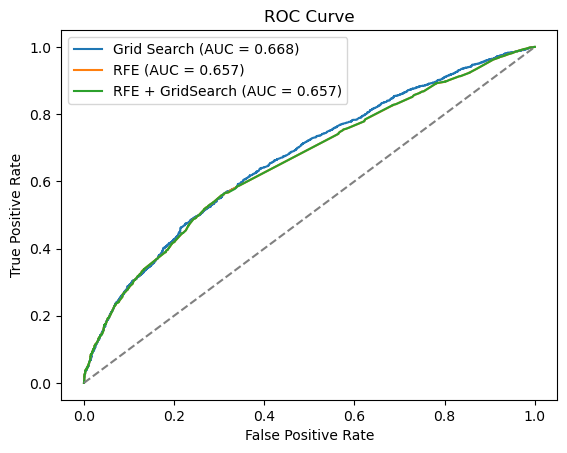

In [499]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba_gs = grid_search.best_estimator_.predict_proba(X_test)
y_pred_proba_rfe = rfe.estimator_.predict_proba(X_test_sel)
y_pred_proba_rfe_grid = rfe_grid_search.best_estimator_.predict_proba(X_test_sel)

roc_index_gs = roc_auc_score(y_test, y_pred_proba_gs[:, 1])
roc_index_rfe = roc_auc_score(y_test, y_pred_proba_rfe[:, 1])
roc_index_rfe_grid = roc_auc_score(y_test, y_pred_proba_rfe_grid[:, 1])

fpr_gs, tpr_gs, _ = roc_curve(y_test, y_pred_proba_gs[:, 1])
fpr_rfe, tpr_rfe, _ = roc_curve(y_test, y_pred_proba_rfe[:, 1])
fpr_rfe_grid, tpr_rfe_grid, _ = roc_curve(y_test, y_pred_proba_rfe_grid[:, 1])

plt.plot(fpr_gs, tpr_gs, label=f"Grid Search (AUC = {roc_index_gs:.3f})")
plt.plot(fpr_rfe, tpr_rfe, label=f"RFE (AUC = {roc_index_rfe:.3f})")
plt.plot(fpr_rfe_grid, tpr_rfe_grid, label=f"RFE + GridSearch (AUC = {roc_index_rfe_grid:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


